In [1]:
from typing import Optional
import math
import random


def duration_log_normal(duration: float, sigma: float = 0.2, round_decimal: int = 0, seed: Optional[int] = None) -> float:
    """
    Returns a log-normal distributed duration whose expected value in real space
    is approximately equal to the given `duration`.

    :param duration: Expected mean duration in real space.
    :param sigma: Standard deviation in log space (must be non-negative).
    :param round_decimal: Number of decimal places to round the result.
    :param seed: Optional random seed for reproducibility.
    :return: A sampled duration from the log-normal distribution.
    """
    sigma =max(sigma, - sigma)

    rnd_numb_gen = random.Random(seed) if seed is not None else random

    # Compute mu so that the expected value in real space is approximately equal to `duration` (E[X] ≈ duration)
    mu = math.log(duration) - 0.5 * sigma ** 2

    result = rnd_numb_gen.lognormvariate(mu, sigma)

    return round(result, round_decimal)

In [2]:
import matplotlib as mpl
mpl.rcdefaults()

In [3]:
import re
from src.domain.orm_models import JobOperation

def _seed_from_op(op) -> int:
    """
    Builds a deterministic seed from (Job, Operation).

    Expected job format: <value1>-<value2>-<value3>.
    Uses only <value1> and <value3>.

    :param op: Operation instance.
    :return: Deterministic integer seed.
    """
    job_id = str(op.job_id)

    # Extract first and last numeric group
    parts = re.findall(r"\d+", job_id)
    if len(parts) >= 2:
        job_digits = f"{parts[0]}{parts[-1]}"
    else:
        job_digits = "".join(parts)  # Fallback: take everything

    return int(f"{job_digits}{op.position_number}")


def simulated_duration_from_op(op: JobOperation, sigma: float = 0.2, round_decimal: int = 0, extra_seed: int = 0) -> float:
    """
    Generates a simulated duration for an operation via ``duration_log_normal``.

    Uses a stable seed based on (Job, Operation).

    :param op: Operation instance.
    :param sigma: Standard deviation in log space.
    :param round_decimal: Number of decimal places to round the result.
    :param extra_seed: Optional additional offset added to the base seed.
    """
    duration = op.duration
    seed = _seed_from_op(op)
    return duration_log_normal(duration, sigma=sigma, round_decimal=round_decimal, seed=seed + extra_seed)


In [4]:
import re

def _seed_from_row(job_id: str, operation: int) -> int:
    """
    Builds a deterministic seed from (Job, Operation).
    
    Expected job format: <value1>-<value2>-<value3>.
    Uses only <value1> and <value3>.
    """
    job_id = str(job_id)
    # Extract first and last numeric group
    parts = re.findall(r"\d+", job_id)
    if len(parts) >= 2:
        job_digits = f"{parts[0]}{parts[-1]}"
    else:
        job_digits = "".join(parts)  # fallback

    return int(f"{job_digits}{int(operation):02d}")  # pad op to 2 digits


In [5]:
from src.domain.Query import JobQuery

jobs = JobQuery.get_by_source_name("Fisher and Thompson 10x10")

#for job in jobs[:3]:
#    for op in job.operations:
#        print(op, simulated_duration_from_op(op))

In [6]:
from typing import Iterable
from src.domain.orm_models import Job
import pandas as pd

def make_jobs_dataframe(jobs: Iterable[Job], sigma: float = 0.2, round_decimal: int = 0) -> pd.DataFrame:
    """
    Build a DataFrame with job operations and simulated durations.

    :param jobs: List of Job objects (each with .id, .routing_id, .operations).
    :param sigma: Standard deviation in log space for simulated duration.
    :param round_decimal: Number of decimal places to round simulated durations.
    :return: Pandas DataFrame with Job, Routing_ID, Operation, Duration, Simulation Duration.
    """
    records = []
    for job in jobs:
        for op in job.operations:  # each operation individually
            records.append({
                "Job": job.id,
                "Routing_ID": job.routing_id,
                "Operation": op.position_number,
                "Duration": op.duration,
                "Simulation Duration": simulated_duration_from_op(op, sigma=sigma, round_decimal=round_decimal)
            })

    return pd.DataFrame(records).sort_values(by=["Job", "Operation"]).reset_index(drop=True)

In [7]:
df_jobs = make_jobs_dataframe(jobs, sigma=0.3, round_decimal=0)

# Regex: drei Gruppen mit Ziffern, Bindestriche dazwischen
df_jobs["Job"] = df_jobs["Job"].str.replace(
    r"^(\d+)-\d+-(\d+)$", r"\1-\2", regex=True
)

# Keine Duplikate
df_jobs = df_jobs.drop_duplicates(subset=["Job"], keep="first").reset_index(drop=True)
df_jobs

,Job,Routing_ID,Operation,Duration,Simulation Duration
0,01-0000,01-07,0,31,36.0
1,01-0001,01-06,0,46,44.0
2,01-0002,01-01,0,43,33.0
3,01-0003,01-05,0,84,89.0
4,01-0004,01-04,0,14,14.0
...,...,...,...,...,...
9013,01-9013,01-06,0,46,42.0
9014,01-9014,01-08,0,76,58.0
9015,01-9015,01-02,0,91,74.0
9016,01-9016,01-04,0,14,13.0


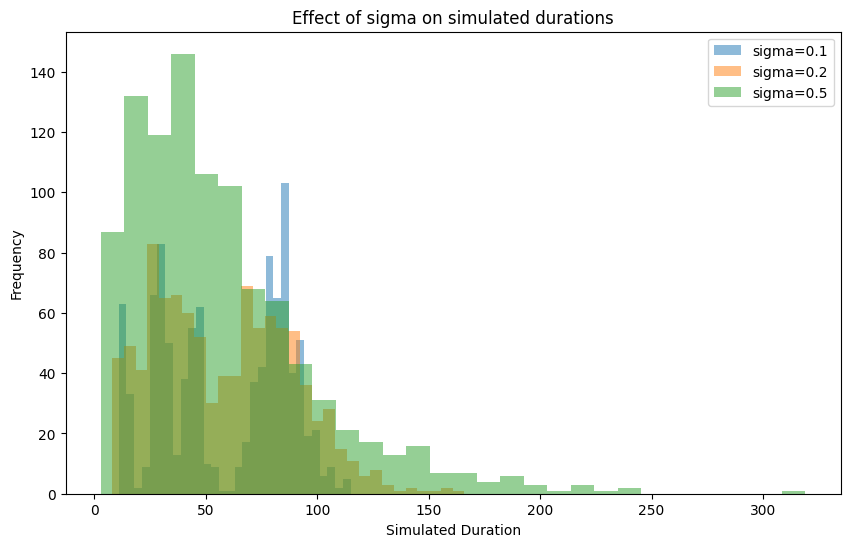

In [8]:
import matplotlib.pyplot as plt

# Eine Stichprobe von Processing Times nehmen
sample_durations = df_jobs["Duration"].sample(1000, random_state=42)

sigmas = [0.1, 0.2, 0.5]

plt.figure(figsize=(10, 6))

for sigma in sigmas:
    simulated = [
        duration_log_normal(d, sigma=sigma, round_decimal=0)
        for d in sample_durations
    ]
    plt.hist(simulated, bins=30, alpha=0.5, label=f"sigma={sigma}")

plt.xlabel("Simulated Duration")
plt.ylabel("Frequency")
plt.title("Effect of sigma on simulated durations")
plt.legend()
plt.show()


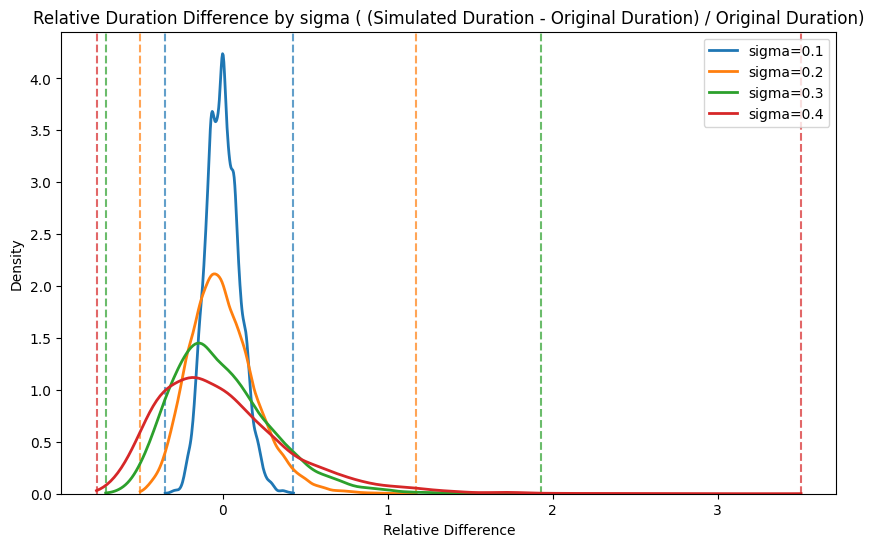

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_relative_deviation_kde(df_jobs, sigmas, round_decimal: int = 0, bins: int = 60):
    """
    Plot KDEs and histograms of relative deviations for different sigma values.

    :param df_jobs: DataFrame with a column 'Duration' (original processing times).
    :param sigmas: Iterable of sigma values to compare.
    :param round_decimal: Number of decimal places to round simulated durations.
    :param bins: Number of bins for histograms.
    :return: matplotlib Figure object.
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    for sigma in sigmas:
        # Compute relative deviations
        rel_diffs = [
            (duration_log_normal(d, sigma=sigma, round_decimal=round_decimal) - d) / d
            for d in df_jobs["Duration"]
        ]

        # KDE curve
        sns.kdeplot(rel_diffs, label=f"sigma={sigma}", linewidth=2, cut=0, ax=ax)
        color = ax.get_lines()[-1].get_color()

        # Histogram (same color, faded, no label)
        #ax.hist(rel_diffs, bins=bins, alpha=0.25, density=True, color=color)

        # Min/Max lines
        xmin, xmax = min(rel_diffs), max(rel_diffs)
        ax.axvline(xmin, color=color, linestyle="--", alpha=0.7)
        ax.axvline(xmax, color=color, linestyle="--", alpha=0.7)

    ax.set_xlabel("Relative Difference")
    ax.set_ylabel("Density")
    ax.set_title("Relative Duration Difference by sigma ( (Simulated Duration - Original Duration) / Original Duration)")
    ax.legend(loc="upper right")

    return fig



fig = plot_relative_deviation_kde(df_jobs, sigmas=[0.1, 0.2, 0.3, 0.4])
plt.show()

In [209]:
# --- Imports ---
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler
from matplotlib import rcParams
import matplotlib as mpl

# Reset Matplotlib defaults (falls viel im Notebook verändert wurde)
mpl.rcdefaults()


# --- Style-Setter ---
def set_latex_style(mono: bool = False):
    """
    Set LaTeX-like clean style.
    - Horizontal grid on y-axis
    - Native ticks (Matplotlib default)
    - Colors (Tab10) or monochrome gray tones if mono=True
    """
    sns.set_style("white")
    sns.set_context("paper")
    rcParams.update({
        "axes.grid": True,              # horizontale Gitterlinien
        "axes.grid.axis": "y",
        "grid.linestyle": "--",
        "grid.alpha": 0.4,

        "axes.spines.top": False,       # obere Rahmenlinie weg
        "axes.spines.right": False,     # rechte Rahmenlinie weg

        "legend.frameon": True,
        "legend.facecolor": "white",
        "legend.edgecolor": "0.85",

        "lines.linewidth": 1.6,

        # Ticks: unten/links sichtbar, innen gerichtet
        "xtick.bottom": True,
        "xtick.top": False,
        "ytick.left": False,
        "ytick.right": False,
        "xtick.direction": "in",
        "ytick.direction": "in",
    })

    if mono:
        rcParams["axes.prop_cycle"] = cycler(color=["0.15", "0.35", "0.55", "0.75"])
    else:
        rcParams["axes.prop_cycle"] = cycler(color=plt.cm.tab10.colors)


# --- Seed-Helfer aus (Job, Operation) ---
def _seed_from_row(job_id: str, operation: int) -> int:
    """
    Builds a deterministic seed from (Job, Operation).
    Expected job format: <value1>-<value2>-<value3>. Uses only <value1> and <value3>.
    """
    job_id = str(job_id)
    parts = re.findall(r"\d+", job_id)
    if len(parts) >= 2:
        job_digits = f"{parts[0]}{parts[-1]}"
    else:
        job_digits = "".join(parts)  # Fallback
    return int(f"{job_digits}{int(operation)}")


# --- Plot-Funktion ---
def plot_relative_deviation_kde(
    df_jobs,
    sigmas,
    round_decimal: int = 0,
    x_min: float = None,
    x_max: float = None,
    x_step: float = None,
    job_column: str = "Job",
    op_column: str = "Operation"
):
    """
    Plot KDEs of relative deviations for different sigma values.
    Uses deterministic seeds per (Job, Operation) for reproducibility.
    Draws custom axis arrowheads at the top (y-axis) and right (x-axis).
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    for sigma in sigmas:
        rel_diffs = []
        for _, row in df_jobs.iterrows():
            d = row["Duration"]
            seed = _seed_from_row(row[job_column], row[op_column])
            sim = duration_log_normal(d, sigma=sigma, round_decimal=round_decimal, seed=seed)
            rel_diffs.append((sim - d) / d)

        sns.kdeplot(rel_diffs, linewidth=2, cut=0, ax=ax, label=fr"$\sigma={sigma}$")
        color = ax.get_lines()[-1].get_color()

        # Min/Max in gleicher Farbe
        xmin, xmax = min(rel_diffs), max(rel_diffs)
        ax.axvline(xmin, color=color, linestyle="--", alpha=0.8, linewidth=1.2)
        ax.axvline(xmax, color=color, linestyle="--", alpha=0.8, linewidth=1.2)

    # Labels
    ax.set_xlabel(
        r"$\frac{\mathrm{simulierte\ Dauer}\ -\ \mathrm{originale\ Dauer}}{\mathrm{originale\ Dauer}}$",
        fontsize=13
    )
    ax.set_ylabel(r"$\mathrm{Dichte}$", fontsize=10)
    ax.legend(
    loc="upper left",
    bbox_to_anchor=(0.98, 0.99),
    borderaxespad=0,
    frameon=True
)

    # Optionale X-Achsenbegrenzung und Ticks
    if x_min is not None or x_max is not None:
        ax.set_xlim(left=x_min, right=x_max)
    if x_step is not None:
        left, right = ax.get_xlim()
        left = left if x_min is None else x_min
        right = right if x_max is None else x_max
        ax.set_xticks(np.arange(left, right+0.001, x_step))

    # --- Pfeilspitzen an Achsen (wie Gantt) ---
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()


    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)



    # x-Achse mit Pfeil nach rechts
    ax.annotate("",
        xy=(xmax+0.1, ymin), xytext=(xmin-0.005, ymin),
        arrowprops=dict(arrowstyle="->", lw=1.2, color="black"),
        annotation_clip=False
    )

    # y-Achse mit Pfeil nach oben
    ax.annotate("",
        xy=(xmin+0.002, ymax), xytext=(xmin+0.002, ymin-0.008),
        arrowprops=dict(arrowstyle="->", lw=1.2, color="black"),
        annotation_clip=False
    )


    return fig


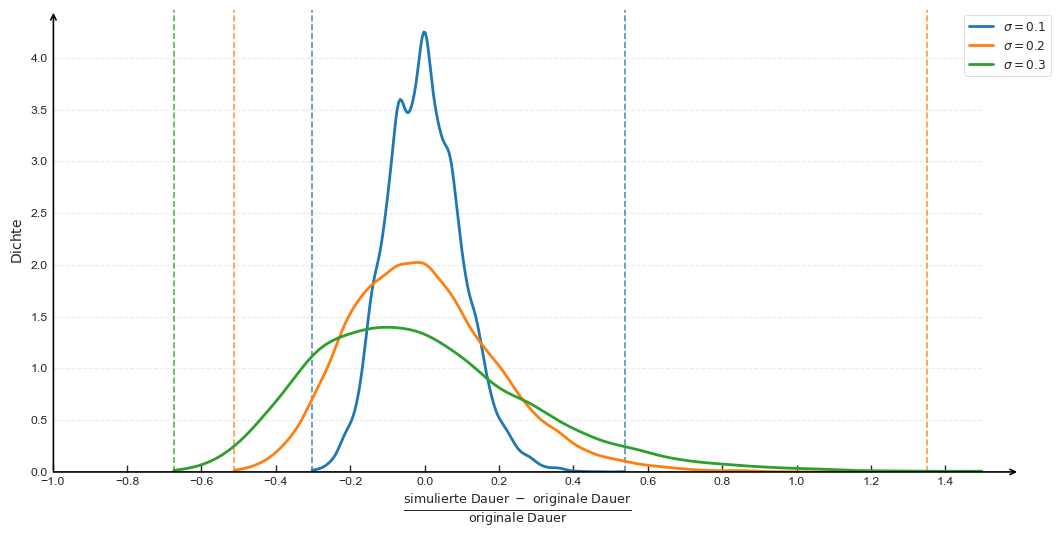

In [216]:
# Style setzen und Plot aufrufen
set_latex_style(mono=False)

fig = plot_relative_deviation_kde(
    df_jobs,
    sigmas=[0.10, 0.2, 0.3],
    x_min=-1, x_max=1.5, x_step=0.2
)

plt.show()